# GDP in German Federal States

<img src="imgs/eck.jpeg">

## Required Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Data Source

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_German_states_by_GDP"

Content of the Wikipedia page:
* List of German states by GDP in 2015
* List of German states by GDP in 2013
* List of German states by GDP in 2012
* List of German states by GDP in 2011
* List of German states by GDP in 2010
* List of German states by GDP in 2009
* List of German states by GDP in 2008

**NOTE!** List for 2014 is missing (Missing data is a very common case in practice)

In [3]:
# requirements: https://stackoverflow.com/questions/34555135/pandas-read-html
# pd.read_html(url)[year_table_map[2015]]

# Methods to be used (Make sure to run all these cells)

In [4]:
year_table_map = {
    2015:3,
    2013:4,
    2012:5,
    2011:6,
    2010:7,
    2009:8,
    2008:9
}

In [5]:
def calculate_population(gdp,gdp_pc):
    return int((gdp*1000000000)/gdp_pc)

def get_population():
    global year_table_map
    df = pd.read_html(url)
#     print(df)
    df = pd.read_html(url)[year_table_map[2015]]
#     print(df)
    df.columns = ["STATE", "RANK", "GDP_EUR", "GDP_USD", "GDP_PC"]
    df = df.drop(["RANK","GDP_USD"],axis=1)
    df = df[~df["STATE"].isin(["States","Germany","Former GDR states and all of Berlin"])]
    df[["GDP_EUR","GDP_PC"]] = df[["GDP_EUR", "GDP_PC"]].apply(pd.to_numeric)
    df["POPULATION"] = df.apply(lambda x: calculate_population(x["GDP_EUR"], x["GDP_PC"]), axis=1)
    df = df[["STATE", "POPULATION"]]
    return df

POPULATION = get_population()

def population_for_state(state):
    global POPULATION
    return POPULATION[POPULATION["STATE"] == state]["POPULATION"].values[0]

def add_per_capita(x):
    global POPULATION
    gdp = x["GDP_EUR"]
    state = x["STATE"]
    population = population_for_state(state)
    return (float(gdp)*1000000000)/population

def plot_population(population_df):
    ax = sns.barplot(population_df["POPULATION"],population_df["STATE"],estimator=abs)
    plt.title("States by Population")
    ax.set(xlabel='POPULATION', ylabel='STATE')
#     plt.xticks(population_df["POPULATION"].valu)

def get_table_for_year(url, year, no_per_capita=True):
    """ Returns datafame representation of the table on wikipedia page
    """
    global year_table_map, POPULATION
    
    if year not in year_table_map.keys():
        return "There is no table for the input year on the Wikipedia page"
    
    df = pd.read_html(url)[year_table_map[year]]
    if year == 2015:
        df.columns = ["STATE", "RANK", "GDP_EUR", "GDP_USD", "GDP_PC"]
        df = df[~df["STATE"].isin(["States","Germany","Former GDR states and all of Berlin"])]
        df[["RANK","GDP_EUR","GDP_USD","GDP_PC"]] = df[["RANK","GDP_EUR","GDP_USD","GDP_PC",]].apply(pd.to_numeric)
        df = df.drop(["GDP_USD"], axis=1)
        if no_per_capita:
            df = df.drop(["GDP_PC", "GDP_USD"], axis=1)
    else: 
        df.columns = ["STATE", "RANK", "GDP_EUR", "GDP_USD", "GDP_SHARE"]
        df = df[~df["STATE"].isin(["States","Germany","Former GDR states and all of Berlin"])]
        df[["RANK","GDP_EUR","GDP_USD"]] = df[["RANK","GDP_EUR","GDP_USD"]].apply(pd.to_numeric)
        df = df.drop(["GDP_SHARE", "GDP_USD"], axis=1)
        if not no_per_capita:
            df["GDP_PC"] = df.apply(lambda x: add_per_capita(x), axis=1)
            
    return df

def plot_gdp_per_capita(year):
    df = get_table_for_year(url, 2015, no_per_capita=False)
    ax = sns.barplot(df["GDP_PC"],df["STATE"],estimator=abs)
    plt.title("States by GDP per capita")
    ax.set(xlabel='GDP PER CAPITA', ylabel='STATE')
    
def merge_tables(years):
    df_lst = []
    for year in years:
        df = get_table_for_year(url, year, no_per_capita=False)
        df["YEAR"] = [year]*len(df)
#         df = df
        df_lst.append(df)
    return pd.concat(df_lst).reset_index(drop=True)

def plot_gdp_over_time(all_tables, states=["Rhineland-Palatinate"]):
    df = all_tables[all_tables["STATE"].isin(states)]
    df['UNIT'] = ['EUR']*len(df)
    sns.tsplot(df, time="YEAR",condition="STATE", unit="UNIT", value="GDP_EUR")

def get_stats(variable):
    if variable == "GDP_EUR":
        unit = "billion"
    elif variable == "GDP_PC":
        unit = "thousands"
    else:
        unit = ""
    
    print("Average {}: {} ({})".format(variable,df[variable].mean(), unit))
    print("Median {}: {} ({})".format(variable,df[variable].median(),unit))
    print("Minimal {}: {} ({})".format(variable,df[variable].min(),unit))
    print("Maximal {}: {} ({})".format(variable,df[variable].max(),unit))

# Aproximating the population

As GDP per capita is given for year 2015 we can aproximate the population of each Bundesland and asume that the populations did not change dramaticaly in the meantime.

**The population will be used to aproximate GDP PER CAPITA where it is missing**

In [6]:
POPULATION = get_population()
POPULATION

,STATE,POPULATION
2,North Rhine-Westphalia,17683037
3,Bavaria,12744592
4,Baden-Württemberg,10777564
6,Hesse,6116221
7,Lower Saxony,7860443
8,Rhineland-Palatinate,4021179
9,Berlin,3485025
10,Saxony,4055947
11,Hamburg,1770172
12,Schleswig-Holstein,2840976


## Try out states you find interesting!

In [7]:
population_for_state("Bavaria")

12744592

## Let's plot the population!

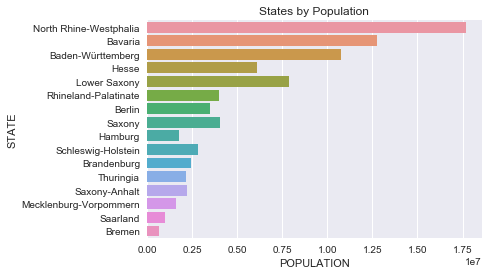

In [8]:
plot_population(POPULATION)

# Scraping data from Wikipedia 

Now, lets download data from the web page. Python has a nice feature that make it easy to download tables from websites automaticaly. For this task, we need just one line of code. However, data usually needs to be procesed and cleaned. The columns we need are:
* STATE - Federal states {NRW, Bavaria, etc..}
* RANK - Best ranked state has value 1
* GDP_EUR - total GDP for state in EUR **BILIONS**
* GDP_PC - GDP per capita **THOUSANDS**

In [9]:
get_table_for_year(url, 2008,no_per_capita=True)

,STATE,RANK,GDP_EUR
2,North Rhine-Westphalia,1,547.54
3,Bavaria,2,444.81
4,Baden-Württemberg,3,365.06
5,Hesse,4,221.35
6,Lower Saxony,5,213.09
7,Rhineland-Palatinate,6,106.37
8,Saxony,7,94.92
9,Berlin,8,88.58
10,Hamburg,9,87.48
11,Schleswig-Holstein,10,73.94


Looking at the page, we can see that GDP per capita is specified only for years 2015 and 2008. This information is rather useful, it is GDP divided by the population of a state. For example, [India ranks 7th in the world by total GDP](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)) which means it is a very large economy, but when the GDP is dividide by the population of [India takes the 122nd place in the world](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita), which means it's citizens are not among the richer in todays standings.

But, if you remember, we have calculated the populations of all Federal states and this means we can aproximate GDP per capita for them! Just add a parameter **no_per_capita** to False.

In [10]:
get_table_for_year(url, 2015, no_per_capita=False)

,STATE,RANK,GDP_EUR,GDP_PC
2,North Rhine-Westphalia,1,645.590,36509
3,Bavaria,2,549.190,43092
4,Baden-Württemberg,3,460.687,42745
6,Hesse,4,263.444,43073
7,Lower Saxony,5,258.530,32890
8,Rhineland-Palatinate,6,131.951,32814
9,Berlin,7,124.161,35627
10,Saxony,8,112.658,27776
11,Hamburg,9,109.271,61729
12,Schleswig-Holstein,10,85.610,30134


# Some stats

In [11]:
df = get_table_for_year(url, 2015, no_per_capita=False)

In [12]:
get_stats("GDP_EUR")

Average GDP_EUR: 189.11881250000002 (billion)
Median GDP_EUR: 110.96449999999999 (billion)
Minimal GDP_EUR: 31.59 (billion)
Maximal GDP_EUR: 645.59 (billion)


In [13]:
get_stats("GDP_PC")

Average GDP_PC: 35772.8125 (thousands)
Median GDP_PC: 34149.5 (thousands)
Minimal GDP_PC: 24909 (thousands)
Maximal GDP_PC: 61729 (thousands)


# Lets se which states have the richest population!

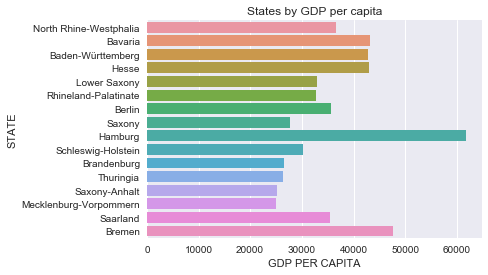

In [14]:
plot_gdp_per_capita(2015)

## Lets see how GDP changed over the years!

In [15]:
df = merge_tables([2008,2009,2010,2011,2012,2013,2015])

In [16]:
df.head(20) #first 20 rows

,STATE,RANK,GDP_EUR,GDP_PC,YEAR
0,North Rhine-Westphalia,1,547.54,30964.138117,2008
1,Bavaria,2,444.81,34901.862688,2008
2,Baden-Württemberg,3,365.06,33872.218249,2008
3,Hesse,4,221.35,36190.647787,2008
4,Lower Saxony,5,213.09,27109.159115,2008
5,Rhineland-Palatinate,6,106.37,26452.440938,2008
6,Saxony,7,94.92,23402.672668,2008
7,Berlin,8,88.58,25417.321253,2008
8,Hamburg,9,87.48,49418.926522,2008
9,Schleswig-Holstein,10,73.94,26026.267029,2008


# How did the GDP of Rheinland-Pfalz change over time?

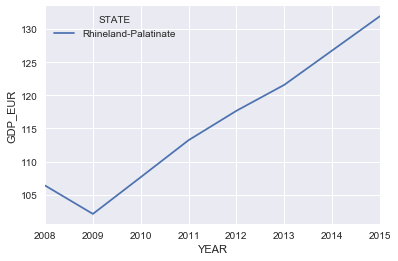

In [17]:
plot_gdp_over_time(df)

## Let's compare states! (Choose on your own)

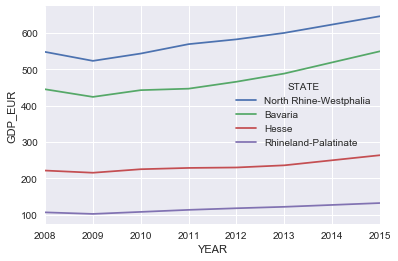

In [18]:
states = ["Rhineland-Palatinate","Bavaria","Hesse","North Rhine-Westphalia"]
plot_gdp_over_time(df, states=states)